<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:2px;border-top:4px solid #FF8200" />


# Adaptive Fourier Filtering


part of 

<font size = "4"> **pyTEMlib**, a **pycroscopy** library </font>


Notebook by 

Gerd Duscher

Materials Science & Engineering<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville


An introduction into Fourier Filtering of images.


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [3]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install git+https://github.com/pycroscopy/pyTEMlib/ -q

# pyTEMlib setup ------------------
else:
    if test_package('sidpy') < '0.0.7':
        print('installing sidpy')
        !{sys.executable} -m pip install  --upgrade sidpy -q     
    if test_package('pyNSID') < '0.0.3':
        print('installing pyNSID')
        !{sys.executable} -m pip install  --upgrade pyNSID -q 
    if test_package('pyTEMlib') < '0.2021.10.1':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

installing sidpy
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
installing pyTEMlib
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
done


## Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 



In [1]:
%pylab  notebook
import sys
sys.path.insert(0,'../../')
import pyTEMlib
import pyTEMlib.file_tools as ft
import pyTEMlib.image_tools as it

print('pyTEMlib version: ', pyTEMlib.__version__)
note_book_version = '2021.10.25'
note_book_name='pyTEMib/notebooks/Imaging/Adaptive_Fourier_Filter'

Populating the interactive namespace from numpy and matplotlib
pyTEMlib version:  0.2021.10.2


## Open File

These datasets are stored in the pyNSID data format (extension: hf5) automatically. 

All results can be stored in that file. 

First we select the file

In [2]:
file_widget = ft.FileWidget()

Select(description='Select file:', layout=Layout(width='70%'), options=('.',), rows=10, value='.')

Now, we open and plot them

In [21]:
import os
directory_name = ft.get_last_path()
dir_list = os.listdir(directory_name)
dir_list
print(directory_name)

/mnt/c/Users/gdusc/Documents/Github/Aluminum_Alloys/structures


In [122]:
def add_to_dict(file_dict, name):
    full_name = os.path.join(file_dict['directory'], name)
    basename, extension = os.path.splitext(name)
    size = os.path.getsize(full_name) * 2 ** -20
    display_name = name
    if len(extension) == 0:
        display_file_list = f' {name}  - {size:.1f} MB' 
    elif extension[0] == 'hf5':
        if extension in ['.hf5']:
            file_list.append(dir_list[i])
            display_file_list = f" {name}  - {size:.1f} MB"
    elif extension in ['.h5', '.ndata']:
        try:
            reader = SciFiReaders.NionReader(full_name)
            dataset_nion = reader.read()
            display_name = dataset_nion.title
            display_file_list = f" {display_name}{extension}  - {size:.1f} MB"
        except:
            display_file_list = f" {name}  - {size:.1f} MB"
    else:
            display_file_list = f' {name}  - {size:.1f} MB'    
    file_dict[name] = {'display_string': display_file_list, 'basename': basename, 'extension': extension, 
                       'size': size, 'display_name': display_name}

    
def update_directory_list(directory_name):
    dir_list = os.listdir(directory_name)

    if '.pyTEMlib.files.pkl' in dir_list:
        with open(os.path.join(directory_name, '.pyTEMlib.files.pkl'), 'rb') as f:
            file_dict = pickle.load(f)
        if directory_name != file_dict['directory']:
            print('directory moved since last time read')
            file_dict['directory'] = directory_name
        dir_list.remove('.pyTEMlib.files.pkl')
        print('found .pyTEMlib.files.pkl')
    else:
        file_dict = {'directory': directory_name}

    # add new files
    file_dict['file_list'] = []
    file_dict['display_file_list'] = []
    file_dict['directory_list'] = []
    
    for name in dir_list:
        if os.path.isfile(os.path.join(file_dict['directory'], name)):
            if name not in file_dict:
                add_to_dict(file_dict, name)
                print('open: ', name)
            file_dict['file_list'].append(name)
            file_dict['display_file_list'].append(file_dict[name]['display_string'])
        else:
            file_dict['directory_list'].append(name)
    remove_item = [] 
    
    # delete items of deleted files
    save_pickle = False
    
    for name in file_dict.keys():
        if name not in dir_list and name not in ['directory', 'file_list', 'directory_list', 'display_file_list']:
            remove_item.append(name)
        else:
            if 'extension' in file_dict[name]:
                save_pickle = True
    for item in remove_item:
        file_dict.pop(item)

    if save_pickle:
        with open(os.path.join(file_dict['directory'], '.pyTEMlib.files.pkl'), 'wb') as f:
            pickle.dump(file_dict, f)
    return file_dict

In [117]:
import os
import pickle

directory_name = os.path.split(file_widget.file_name)[0]
print(directory_name)
file_dict = update_directory_list('.')


directory moved since last time read
found .pyTEMlib.files.pkl
open:  Adaptive_Fourier_Filter-Copy1.ipynb
open:  Adaptive_Fourier_Filter.ipynb
open:  colab_plot.py
open:  Copy_of_Register.ipynb
open:  Image_Tools.ipynb
open:  index.rst
open:  Register_Image_Stack.ipynb
open:  Selective_Fourier_Transform.ipynb
open:  Untitled.ipynb


In [38]:
with open(os.path.join(directory_name, '.pyTEMlib.files.pkl'), 'rb') as f:
    file_dict2 = pickle.load(f)
file_dict2

{'directory': '/mnt/c/Users/gdusc/Documents/2021-08-17-PdSe2-US200at100KV-20210913T170959Z-001/2021-08-17-PdSe2-US200at100KV/Nion Swift Library 20210817/Nion Swift Data 13/2021/08/17/20210817-092201',
 '.pyTEMlib.files.pkl': {'display_string': ' .pyTEMlib.files.pkl  - 0.0 MB',
  'basename': '.pyTEMlib.files',
  'extension': '.pkl',
  'size': 0.005063056945800781,
  'display_name': '.pyTEMlib.files.pkl'},
 'data_3WFW5RZP7M43CBKD7O8SABN3E.h5': {'display_string': ' Recording of SuperScan (HAADF).h5  - 20.0 MB',
  'basename': 'data_3WFW5RZP7M43CBKD7O8SABN3E',
  'extension': '.h5',
  'size': 20.012985229492188,
  'display_name': 'Recording of SuperScan (HAADF)'},
 'data_4PJWOLMF6ENB6JXW6JHY03DGO.ndata': {'display_string': ' SuperScan (HAADF) 7.ndata  - 4.0 MB',
  'basename': 'data_4PJWOLMF6ENB6JXW6JHY03DGO',
  'extension': '.ndata',
  'size': 4.003776550292969,
  'display_name': 'SuperScan (HAADF) 7'},
 'data_542DG8ON0YNIWR6MKTBCUVKTI.ndata': {'display_string': ' SuperScan (HAADF).ndata  - 

In [123]:
class FileWidget(object):
    def __init__(self, dir_name=None, extension=['*']):
        self.save_path = False
        self.dir_dictionary = {}
        self.dir_list = ['.', '..']
        self.display_list = ['.', '..']

        if dir_name is None:
            dir_name = get_last_path()
            self.save_path = True
            self.get_directory(dir_name)
        elif os.path.isdir(dir_name):
            self.get_directory(dir_name)
            self.dir_name = dir_name
        else:
            self.dir_name = '.'
            self.get_directory(self.dir_name)

        self.dir_list = ['.']
        self.extensions = extension
        self.file_name = ''

        self.select_files = widgets.Select(
            options=self.dir_list,
            value=self.dir_list[0],
            description='Select file:',
            disabled=False,
            rows=10,
            layout=widgets.Layout(width='70%')
        )
        display(self.select_files)
        self.set_options()
        self.select_files.observe(self.get_file_name, names='value')

    def get_directory(self, directory=None):
        self.dir_name = directory
        self.dir_dictionary = {}
        self.dir_list = []
        self.dir_list = ['.', '..'] + os.listdir(directory)

    def set_options(self):
        self.dir_name = os.path.abspath(os.path.join(self.dir_name, self.dir_list[self.select_files.index]))
        dir_list = os.listdir(self.dir_name)
        file_dict = update_directory_list(self.dir_name)
       
        sort = np.argsort(file_dict['directory_list'])
        self.dir_list = ['.', '..']
        self.display_list = ['.', '..']
        for j in sort:
            self.display_list.append(f" * {file_dict['directory_list'][j]}")
            self.dir_list.append(file_dict['directory_list'][j])

        sort = np.argsort(file_dict['display_file_list'])

        for i, j in enumerate(sort):
            if '--' in dir_list[j]:
                self.display_list.append(f" {i:3} {file_dict['display_file_list'][j]}")
            else:
                self.display_list.append(f" {i:3}   {file_dict['display_file_list'][j]}")
            self.dir_list.append(file_dict['file_list'][j])

        self.dir_label = os.path.split(self.dir_name)[-1] + ':'
        self.select_files.options = self.display_list

    def get_file_name(self, b):

        if os.path.isdir(os.path.join(self.dir_name, self.dir_list[self.select_files.index])):
            self.set_options()

        elif os.path.isfile(os.path.join(self.dir_name, self.dir_list[self.select_files.index])):
            self.file_name = os.path.join(self.dir_name, self.dir_list[self.select_files.index])



In [125]:
file_widget = FileWidget()

Select(description='Select file:', layout=Layout(width='70%'), options=('.',), rows=10, value='.')

found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
open:  Nion Swift Cache 13.nscache
open:  Nion Swift Library 13.nslib
open:  Nion Swift Workspace.nslib
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl
found .pyTEMlib.files.pkl


/home/nyd/.local/lib/python3.8/site-packages/SciFiReaders/readers/SID/Nsid_reader.py:43: FutureWarning: This Reader will eventually be moved to the ScopeReaders package. Be prepared to change your import statements
  warn('This Reader will eventually be moved to the ScopeReaders package'
/home/nyd/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


We really would need an image here


<IPython.core.display.Javascript object>


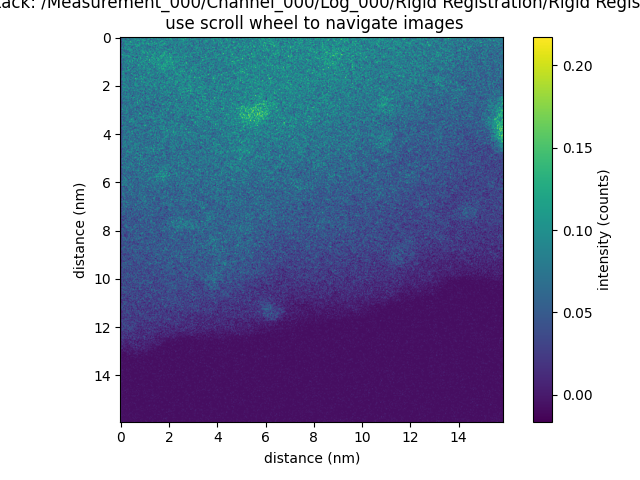

In [39]:
file_name = file_widget.file_name
try:
    dataset.h5_dataset.file.close()
except:
    pass
dataset= ft.open_file(file_name)
if dataset.data_type.name != 'IMAGE':
    print('We really would need an image here')

dataset.plot()

## Power Spectrum of Image

fft :
	smoothing : 1
	minimum_intensity : 1.5516745530082132
	maximum_intensity : 6.579842316152082
source:  NionReader


<IPython.core.display.Javascript object>


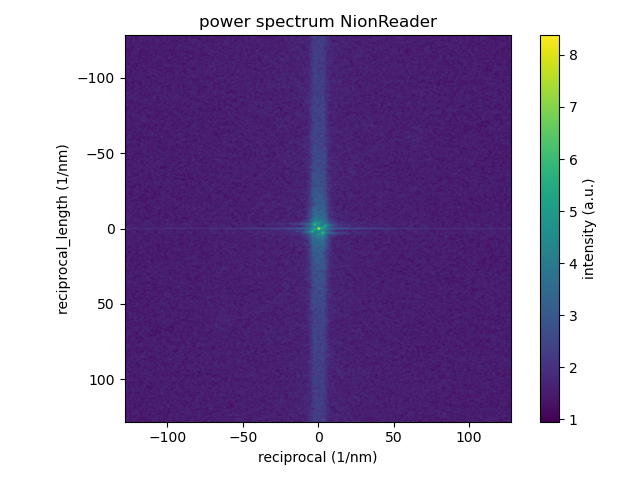

In [199]:
power_spectrum = it.power_spectrum(selection, smoothing=1)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
power_spectrum.plot()

## Spot Detection in Fourier Transform

Found 1241 reflections


<IPython.core.display.Javascript object>


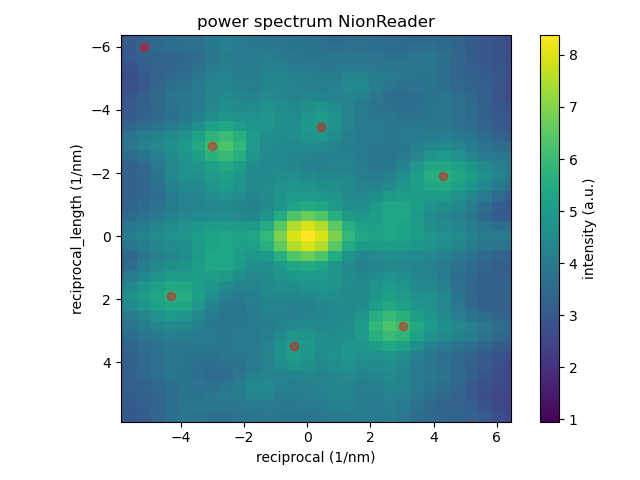

In [203]:
# ------Input----------
spot_threshold=0.04
# ---------------------

spots = it.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)
spots = spots[np.linalg.norm(spots[:,:2],axis=1)<8,:]
spots = spots[np.linalg.norm(spots[:,:2],axis=1)>0.5,:]
power_spectrum.plot()

plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4);

## Adaptive Fourier Filter

<IPython.core.display.Javascript object>


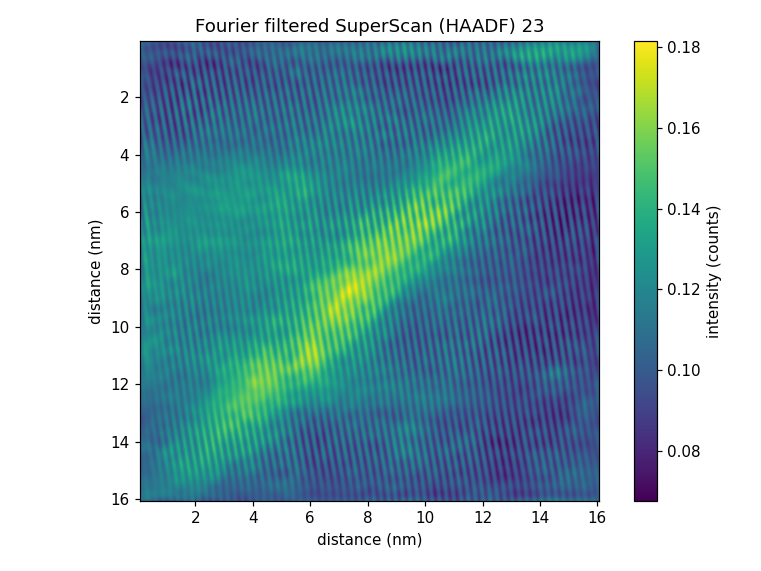

In [35]:
filtered_dataset = it.adaptive_fourier_filter(choose_image.dataset, spots, low_pass=2., reflection_radius=.3)
filtered_dataset.plot()

Let's see what we did - In Fourier space, of course.

<IPython.core.display.Javascript object>


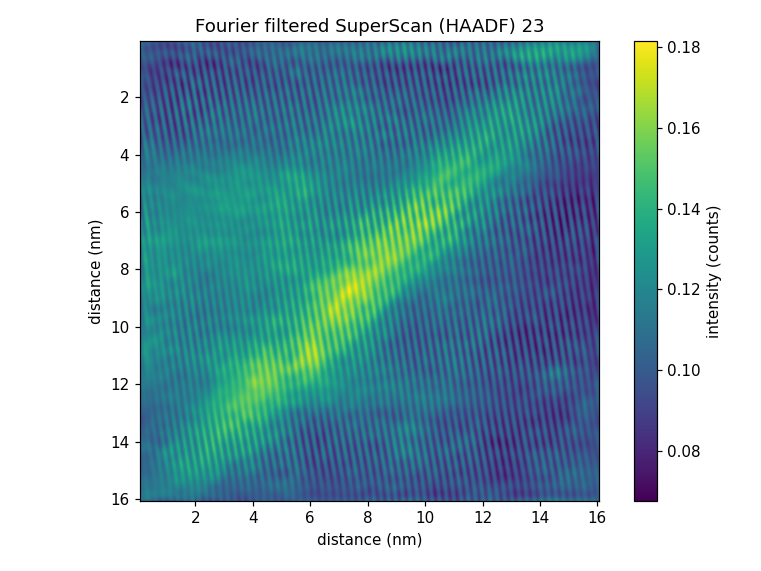

In [39]:
filtered_dataset.view.fig

In [ ]:
filtered_power_spectrum = it.power_spectrum(filtered_dataset, smoothing=0)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
filtered_power_spectrum.plot()

Please note that the spots are ordered from center to outside.

The third parameter of a spot is its angle.

In [ ]:
print(spots[:5])

## Log the result

In [ ]:
results_channel = ft.log_results(dataset.h5_dataset.parent.parent, filtered_dataset)


A tree-like plot of the file

In [ ]:
ft.h5_tree(dataset.h5_dataset.file)

In [ ]:
dataset.h5_dataset.parent

A convenient function to select a dataset (for further processing, visualization or whatever)

In [ ]:
choose_image = ft.ChooseDataset(dataset.h5_dataset.parent.parent)

The selected dataset can then easily be plotted

In [ ]:
choose_image.dataset.plot()

## Close File
let's close the file but keep the filename

In [ ]:
filename = results_channel.file.filename
results_channel.file.close()

## Simulate new notebook
We can now simulate a new notebook and open the file again.



In [ ]:
new_dataset= ft.open_file(filename)
choose_image = ft.ChooseDataset(new_dataset.h5_dataset.parent)

In [ ]:
choose_image.dataset.plot()

We want to make an image operation of the images in the file.

In [ ]:
choose_image = ft.ChooseDataset(new_dataset.h5_dataset.parent.parent)
print('       subtract')
choose_image2 = ft.ChooseDataset(new_dataset.h5_dataset.parent)

In [ ]:
new_image = np.array(choose_image.dataset) - np.array(choose_image2.dataset)
new_image = new_dataset.like_data(new_image)
new_image.plot()

## Close File for Good

In [ ]:
new_dataset.h5_dataset.file.close()